<a href="https://colab.research.google.com/github/carlgran/SIIM_ISIC_Competition/blob/master/SIIM_ISIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# LOAD LIBRARIES
import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt, cv2
from sklearn.impute import SimpleImputer
import tensorflow as tf, re, math

meta_train = pd.read_csv('drive/My Drive/SIIM_data/train.csv')
meta_test =pd.read_csv('drive/My Drive/SIIM_data/test.csv')#/drive/My Drive/SIIM_data/test.csv

y = meta_train.target

# COMBINE TRAIN AND TEST TO ENCODE TOGETHER
cols = meta_test.columns
comb = pd.concat([meta_train[cols],meta_test[cols]],ignore_index=True,axis=0).reset_index(drop=True)

# LABEL ENCODE ALL STRINGS
cats = ['patient_id','sex','anatom_site_general_challenge'] 
for c in cats:
    comb[c],mp = comb[c].factorize()
    #print(mp)
#print('Imputing Age NaN count =',comb.age_approx.isnull().sum())
comb.age_approx.fillna(comb.age_approx.mean(),inplace=True)
comb['age_approx'] = comb.age_approx.astype('int')

# REWRITE DATA TO DATAFRAMES
meta_train[cols] = comb.loc[:meta_train.shape[0]-1,cols].values
meta_test[cols] = comb.loc[meta_train.shape[0]:,cols].values

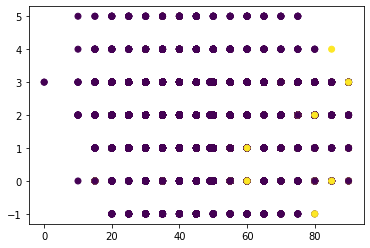

In [ ]:
# Visualize
x,yp,c = meta_train.age_approx, meta_train.anatom_site_general_challenge, y# meta_train.sex, meta_train.target#  
plt.scatter(x,yp,c=c)
plt.show()

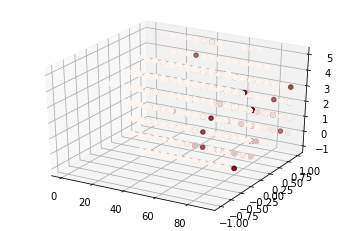

In [ ]:
#Visualize 3D

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

x,yp,z,c = meta_train.age_approx, meta_train.sex, meta_train.anatom_site_general_challenge, meta_train.target==1# meta_train.sex, meta_train.target#  

ax.scatter( x, yp, z, c=c, cmap='Reds')

****

**Training with Logistic Regression in scikit-learn**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc

X = meta_train[cols]

X.drop(["image_name", "patient_id"], axis=1, inplace=True)

# Train-validation split

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.2, test_size=0.2, random_state=0)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Predict probability target
y_pred_p = clf.predict_proba(X_val)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#Optimize F_1 score

prob_thr = np.arange(0.01,0.13,0.001)
f1_scores = []
for pt in prob_thr:
    y_predict = [1 if a[1]>=pt else 0 for a in y_pred_p ]
    f1_scores.append(f1_score(y_val, y_predict))
    #print(y_predict.count(1), f1_score(y_val, y_predict), pt )
max_f1 = np.max(f1_scores) 
c_pt = prob_thr[f1_scores.index(max_f1)]

print('max f1_score:%s'%max_f1, '\nthreshold prob:%s%%'%(np.round(c_pt*100)))
y_predict = [1 if a[1]>=c_pt else 0 for a in y_pred_p ]


max f1_score:0.10989010989010989 
threshold prob:4.0%


AUC:0.68706


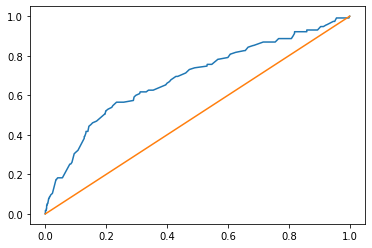

In [ ]:
# ROC and AUC score
y_pred_p[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_p[:,1], pos_label=None)
plt.plot(fpr,tpr)
plt.plot(fpr,fpr)
print('AUC:%s'%np.round(auc(fpr, tpr),5))

*****

**Training with Keras model in TensorFlow**

In [ ]:
# Customize loss functions

import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical

# F_1 Score:

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)#K.round(y_pre[:,1])
    #y_true = y_tru[:,1]
    #print(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1[-1:])

def f1_loss(y_true, y_pred):
    
#     y_pred = y_pre[:,1]
#     y_true = y_tru[:,1]
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1[-1:])


In [ ]:
#Build and compile model

from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model

y_binary = to_categorical(y) #Encode target

X_train, X_val, y_train, y_val = train_test_split(X, y_binary, train_size=0.8, test_size=0.2, random_state=0)

input_layer = Input(shape=(X.shape[1],))
dense_layer_1 = Dense(15, activation='relu')(input_layer)
#dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)
output = Dense(y_binary.shape[1], activation='softmax')(dense_layer_1)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss=f1_loss, optimizer='adam', metrics=['acc', f1])
print(model.summary())
#print(model.compile.__doc__)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 15)                60        
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 32        
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=2000, epochs=100, verbose=0, validation_split=0.2)

In [ ]:
# Validate

score = model.evaluate(X_val, y_val, verbose=1)
y_p = model.predict(X_val)

#y_true, y_pred = np.argmax(y_val, axis=1), np.argmax(y_p, axis=1)

#plt.scatter(X_val['age_approx'],y_pred)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print("F_1 score:",  f1(y_val, y_p).numpy())

208/208 [==============================] - 0s 1ms/step - loss: 0.9488 - acc: 0.9525 - f1: 0.0542
Test Score: 0.9488310813903809
Test Accuracy: 0.952459990978241
F_1 score: 0.097421154


AUC score:0.6617763917918172


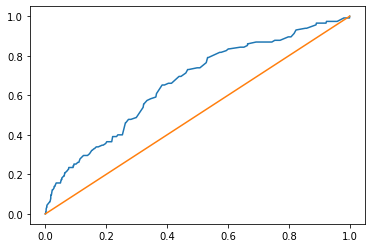

In [ ]:
# ROC and AUC score
y_val_pos = [a[1] for a in y_val ]
y_p_pos = [a[1] for a in y_p ]

fpr, tpr, thresholds = roc_curve(y_val_pos, y_p_pos, pos_label=None)
plt.plot(fpr,tpr)
plt.plot(fpr,fpr)
print("AUC score:%s"%auc(fpr, tpr))


In [ ]:
# check target
ct=0
for a in y_p:
    ct+=1
    if a[1]>=0.5:
        print(a,ct, y_val[ct-1])


[0.16878174 0.83121824] 14 [1. 0.]
[0.39502388 0.6049761 ] 17 [1. 0.]
[0.49526465 0.5047353 ] 29 [1. 0.]
[0.14792672 0.8520733 ] 44 [1. 0.]
[0.25556025 0.7444398 ] 64 [1. 0.]
[0.36724368 0.6327563 ] 84 [1. 0.]
[0.36724368 0.6327563 ] 113 [1. 0.]
[0.24824078 0.7517593 ] 118 [1. 0.]
[0.10722458 0.8927754 ] 193 [1. 0.]
[0.16878174 0.83121824] 200 [1. 0.]
[0.16878174 0.83121824] 201 [1. 0.]
[0.45621103 0.54378897] 208 [1. 0.]
[0.49526465 0.5047353 ] 232 [0. 1.]
[0.39502388 0.6049761 ] 233 [1. 0.]
[0.00766949 0.99233043] 259 [1. 0.]
[0.25556058 0.74443936] 359 [1. 0.]
[0.16878174 0.83121824] 379 [1. 0.]
[0.49526465 0.5047353 ] 386 [1. 0.]
[0.25556058 0.74443936] 426 [0. 1.]
[0.22691041 0.7730896 ] 453 [1. 0.]
[0.10722458 0.8927754 ] 459 [1. 0.]
[0.16878174 0.83121824] 461 [1. 0.]
[0.18595932 0.8140407 ] 466 [1. 0.]
[0.16878174 0.83121824] 491 [1. 0.]
[0.09645716 0.9035428 ] 507 [1. 0.]
[0.16878174 0.83121824] 526 [0. 1.]
[0.10722458 0.8927754 ] 679 [1. 0.]
[0.09645716 0.9035428 ] 691 [1. 0.

**Working with tfrec files**

In [ ]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)
CLASSES = [0,1]

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    #if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
    #    numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = label
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = example['image_name']
    return image, label # returns a dataset of (image, label) pairs

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [ ]:
# INITIALIZE VARIABLES
IMAGE_SIZE= [1024,1024]; BATCH_SIZE = 1
AUTO = tf.data.experimental.AUTOTUNE
TRAINING_FILENAMES = tf.io.gfile.glob('drive/My Drive/SIIM_data/'+'train*.tfrec')
print('There are %i train images'%count_data_items(TRAINING_FILENAMES))

There are 2071 train images


In [ ]:
# DISPLAY TRAIN IMAGES
dataset = load_dataset(TRAINING_FILENAMES, labeled=True)

image = []
label = []

for image_features in dataset.take(100):
    image.append(image_features[0].numpy())
    label.append(image_features[1].numpy())



b'ISIC_3139230'


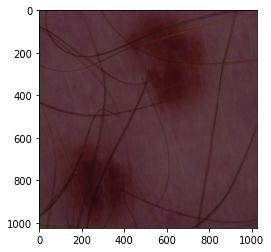

In [ ]:
re_image = 0.5*image[0]
print(label[0])
plt.imshow(re_image)